# Visualizing what convnets learn

## Visualizing intermediate activations

Visualizing intermediate activation consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input.

This gives a view into how an input is decomposed into different filters learned by the network.

Feature maps should be visualized in 3D so be will plot the 3 dimentions as a 3 2D images.

In [4]:
from tensorflow.keras.models import load_model
model = load_model('cats_and_dogs_small_1.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
______________________

In [5]:
img_path = 'data/dogs_cat_dataset/test/cats/cat.1700.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

img_tensor.shape

(1, 150, 150, 3)

In [6]:
import matplotlib.pyplot as plt

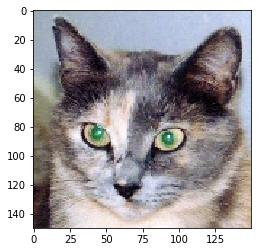

In [7]:
plt.imshow(img_tensor[0])
plt.show()

In [9]:
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(model.input, layer_outputs)

In [10]:
activations = activation_model.predict(img_tensor)

(1, 148, 148, 32)


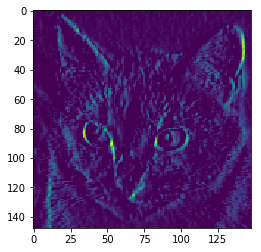

In [11]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.imshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.show()

### Plot all activations

c:\users\guill\anaconda3\envs\p36_tf-gpu\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


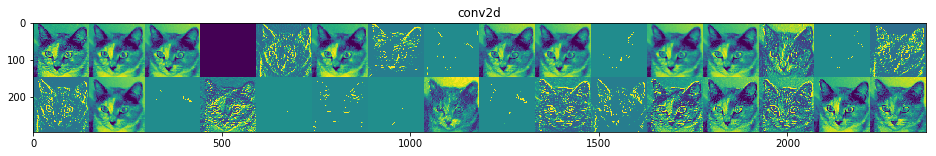

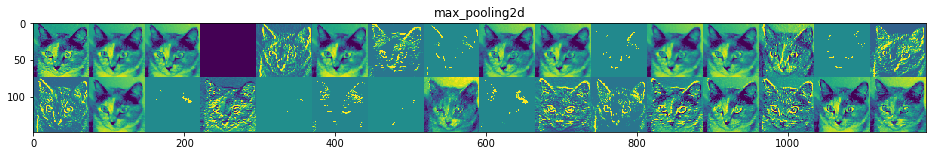

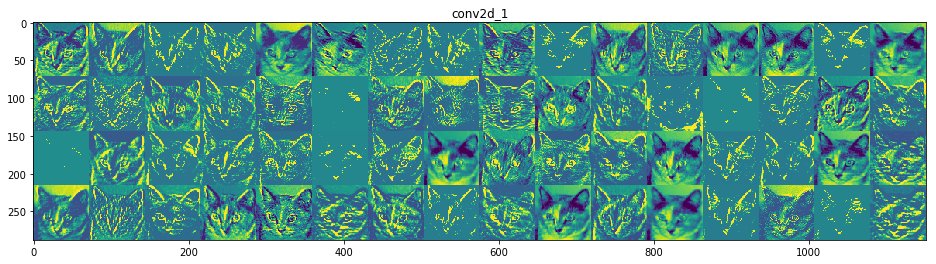

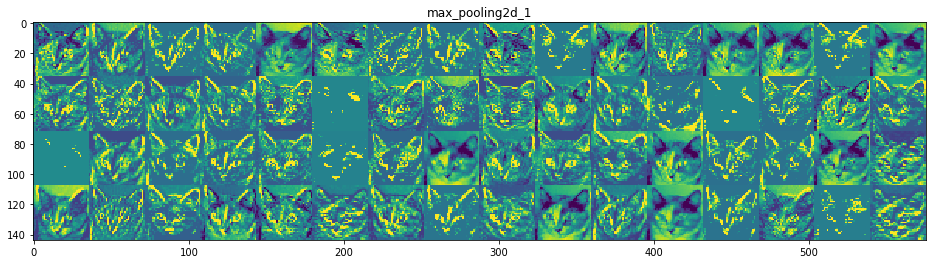

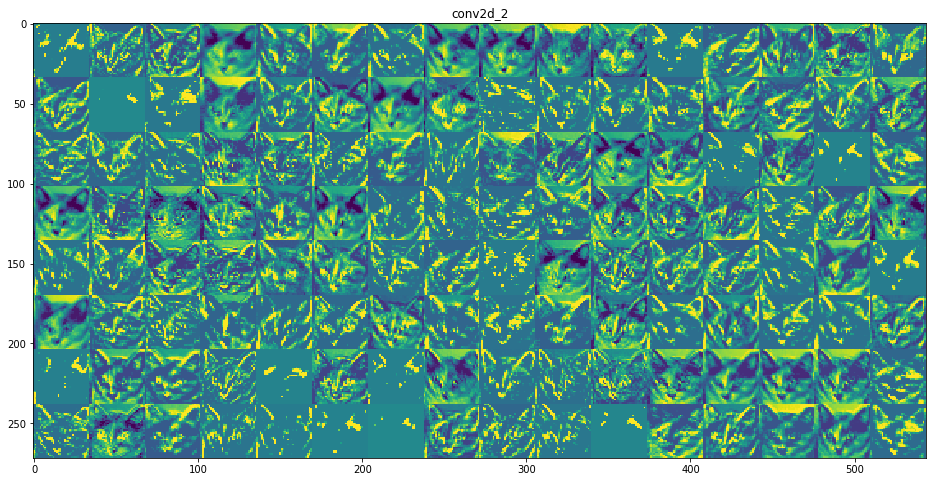

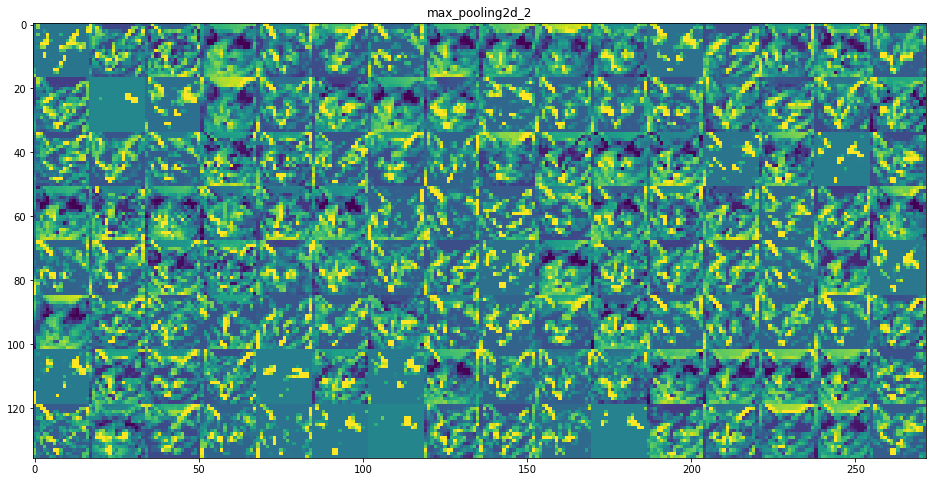

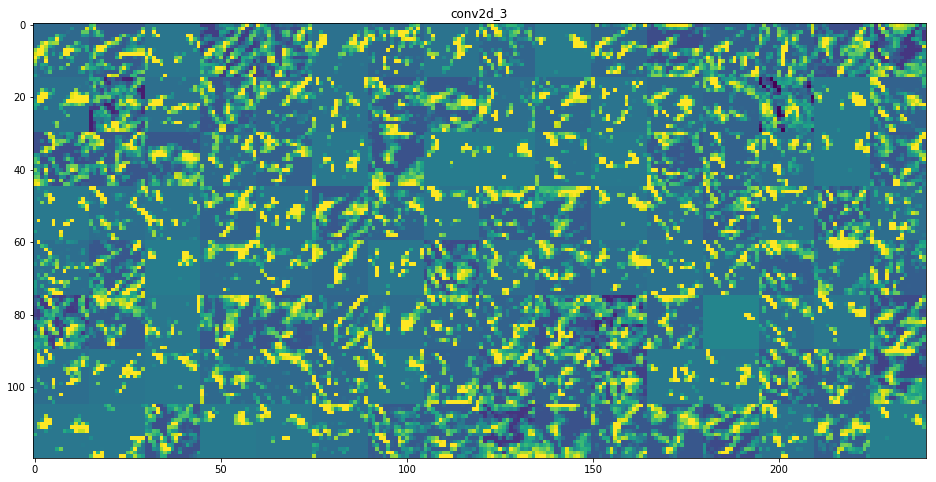

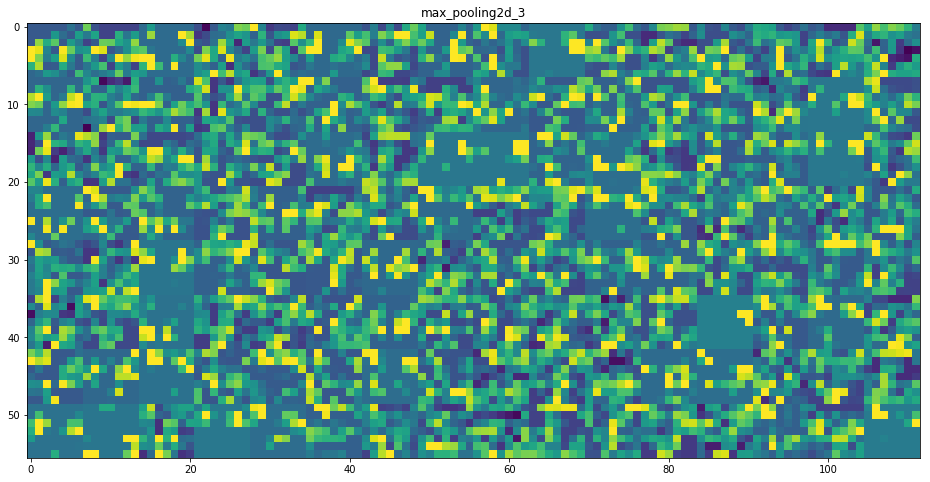

In [13]:
layer_names = [l.name for l in model.layers]

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, : , col * images_per_row + row]
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            display_grid[col * size: (col + 1) * size,
                         row * size: (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], 
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    

## Visualizing convnets filters

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [16]:
grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [17]:
iterate = K.function([model.input], [loss, grads])

loss_values, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [18]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128

step = 1
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [19]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.01
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
    

In [24]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128
    
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        
    return deprocess_image(input_img_data[0])

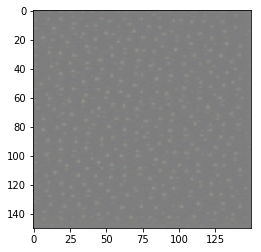

In [29]:
plt.imshow(generate_pattern('block3_conv1', 0))

In [36]:
layer_name = 'block4_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        
        vertical_start = j* size + j * margin 
        vertical_end = vertical_start + size
        
        results[horizontal_start : horizontal_end,
                vertical_start : vertical_end, :] = filter_img

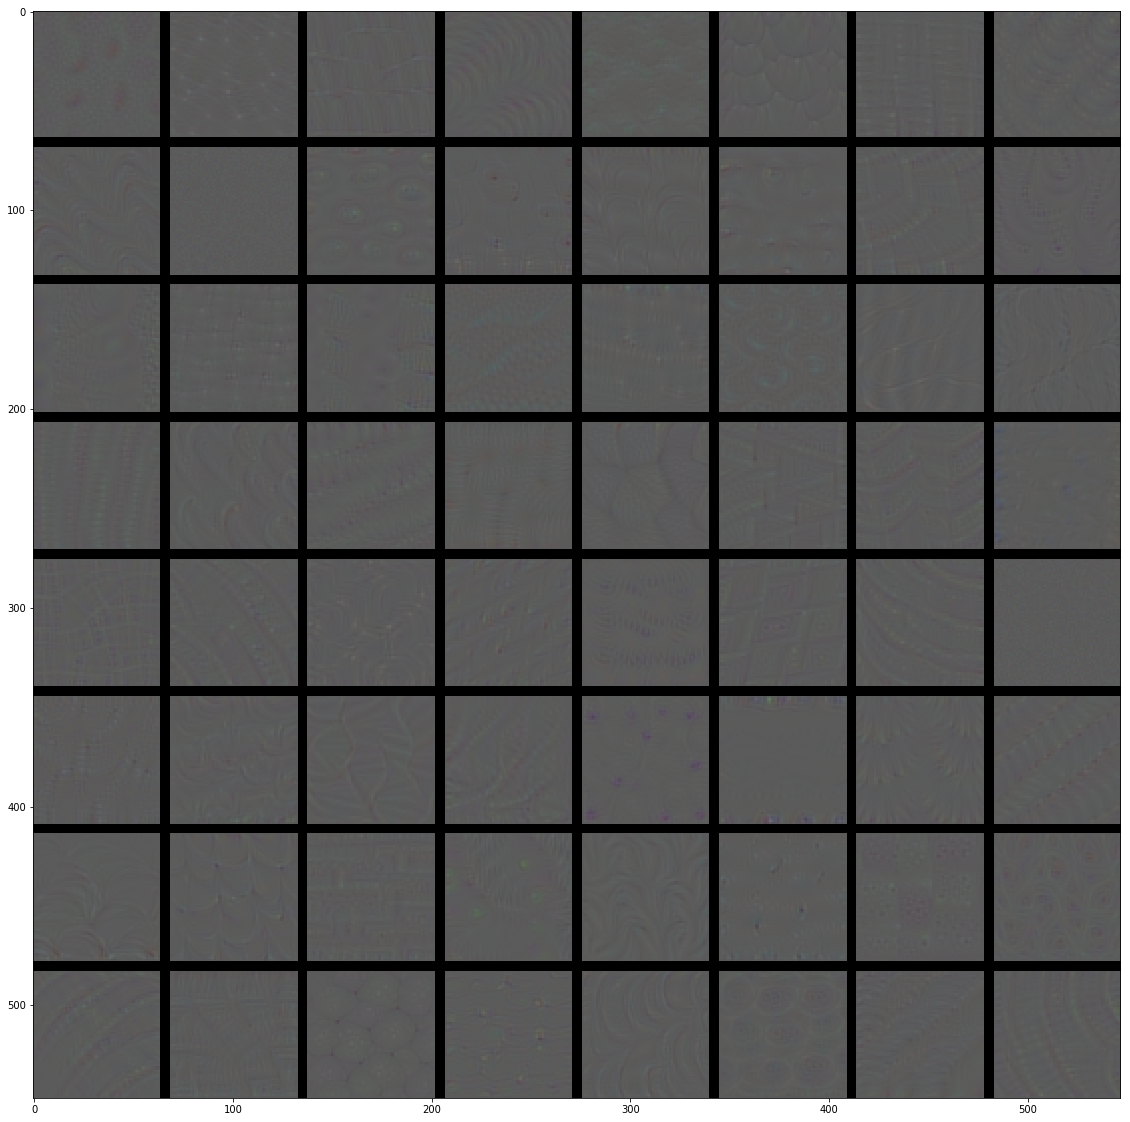

In [37]:
plt.figure(figsize=(20, 20))
plt.imshow(results / 355.)

## Visualizing heatmaps class activations

In [38]:
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 377s 1us/step


In [42]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

img_path = 'data/elephants.jpg'

x = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [43]:
preds = model.predict(x)
print(decode_predictions(preds, top=3))

40960/35363 [==================================] - 0s 6us/step
[[('n02504458', 'African_elephant', 0.57036936), ('n01871265', 'tusker', 0.32464716), ('n02504013', 'Indian_elephant', 0.10496997)]]


### CAM

In [50]:
african_elephant_out = model.output[:, np.argmax(preds)]
last_conv_layer = model.get_layer('block5_conv3')

# Gradient of african elephant class with regard to the outpit feature map fo block5_conv3
grads = K.gradients(african_elephant_out, last_conv_layer.output)[0]
# Tensor of shape (512,) where each entry is the mean intensisty of the gradient over a specific fearure-map channer
pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_value = iterate([x])

for i in range(250):
    conv_layer_value[: , :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_value, axis=-1)

In [47]:
african_elephant_out

<tf.Tensor 'strided_slice_438:0' shape=(?,) dtype=float32>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


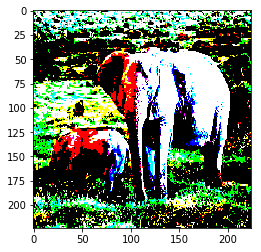

In [53]:
plt.imshow(x[0])

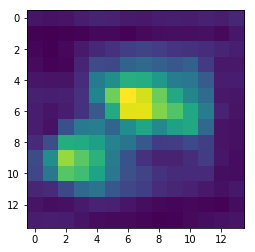

In [51]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)

In [61]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('data/superimposed_elephant.jpg', superimposed_img)

True

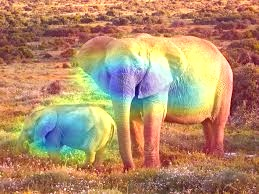